## Train the PF-Controller Neural Network

For each performance metric, train the corresponding particle-filter (PF) controller neural network.

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from src.models.particle_filter.core import ParticleFilter
from src.models.networks.pf_mlp import ParticleFilterMLP
from src.helpers.seed import set_global_seed

from experiment_config import (
    DegModel,DATA_NAME,ESTIMATION_NAME,SEED,PFNET_NAME,LEAKY_SLOPE,HIDDEN_DIMS,PREDICTION_START_IDX,EMA_BETA,USE_LASTOBS_LOSS,N_PARTICLES
)

## Task

In [2]:
perform_name = 'SmLPC'

## Hyper-Parameters

In [3]:
# Training parameters#
# optimization
lr = 5e-4
weight_decay = 0
gradient_clip = 3.0
 


# Early stopping
n_epochs = 5000
patience = 100          # how many eval steps to wait
min_delta = 1e-4       # minimum improvement to count

In [4]:
degmodel_name = DegModel.name()
activation = nn.LeakyReLU(LEAKY_SLOPE)

set_global_seed(SEED)
experiment_dir = Path('experiments')/DATA_NAME

estimation_dir = experiment_dir/ESTIMATION_NAME
degmodel_dir = estimation_dir/degmodel_name
states_dir = degmodel_dir/'states'
pfnet_dir = degmodel_dir /'pf_performs'/PFNET_NAME
checkpoint_path = pfnet_dir / perform_name / "checkpoint.pt"
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

## Import training data

In [ ]:
hi_df = pd.read_csv(estimation_dir/"data_dev.csv")
units = hi_df['unit'].astype(int).unique().tolist()
units 

### Extract degradation onset

In [ ]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [ ]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}

init_ss = {name: {unit: perform[unit].max() for unit in units} for name,perform in performs.items()}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [ ]:
eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time[unit]
    s_data = performs[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [ ]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = DegModel(onset=onsets[unit], init_s=init_ss[perform_name][unit])
        best_model.load_state_dict(
            torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
        )
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net()

In [ ]:
net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=HIDDEN_DIMS,
                        activation=lambda : activation)

optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
optimizer.zero_grad()

In [ ]:
wait = 0             
early_stop = False
ema_loss = None


start_epoch = 0
best_loss = float("inf")
total_loss = 0.0
losses = []
epochs = []
if checkpoint_path.exists():
    ckpt = torch.load(checkpoint_path, weights_only=False)

    net.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_loss = ckpt["best_loss"]
    losses = ckpt["losses"]
    epochs = ckpt["epochs"]

    ema_loss = ckpt.get("ema_loss", None)

    torch.random.set_rng_state(ckpt["rng_torch"])
    np.random.set_state(ckpt["rng_numpy"])

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

In [ ]:
for epoch in range(start_epoch, n_epochs):

    epoch_losses = []

    for eval_unit in np.random.permutation(units):
        optimizer.zero_grad()
        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]

        pf = ParticleFilter(
            base_models=degmodels,
            net=net,
            n_particles=N_PARTICLES,
        ).train()

        unit_loss = 0.0
        n_loss = 0

        for k in range(PREDICTION_START_IDX, len(t_data)):
            
            mixture_dist = pf.step(
                t_obs=t_data[:k+1],
                s_obs=s_data[:k+1],
            )
            init_loss = -1 if USE_LASTOBS_LOSS else k
            last_dist = mixture_dist.distribution(s=s_data[init_loss:])
            nll = -last_dist.log_prob(t_data[init_loss:]).mean()
            unit_loss += nll
            n_loss += 1

        unit_loss = unit_loss / n_loss

        unit_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), gradient_clip)
        optimizer.step()

        epoch_losses.append(unit_loss.item())

    # ---- raw loss ----
    current_loss = float(sum(epoch_losses) / len(epoch_losses))

    # ---- EMA smoothing ----
    if ema_loss is None:
        ema_loss = current_loss
    else:
        ema_loss = EMA_BETA * ema_loss + (1 - EMA_BETA) * current_loss

    print(f"[Epoch {epoch:04d}] loss = {current_loss:.3f} | ema = {ema_loss:.3f}")

    losses.append(current_loss)
    epochs.append(epoch)

    # ---- early stopping on EMA ----
    if ema_loss < best_loss - min_delta:
        best_loss = ema_loss
        wait = 0

        checkpoint = {
            'epoch': epoch,
            'model_state': net.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_loss': best_loss,
            'losses': losses,
            'epochs': epochs,
            'ema_loss': ema_loss,
            "rng_torch": torch.random.get_rng_state(),
            "rng_numpy": np.random.get_state(),
        }

        torch.save(checkpoint, checkpoint_path)
        print("  + saved (best EMA)")

    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping triggered")
            break

[Epoch 0000] loss = 3.573 | ema = 3.573
  + saved (best EMA)
[Epoch 0001] loss = 3.477 | ema = 3.563
  + saved (best EMA)
[Epoch 0002] loss = 3.575 | ema = 3.565
[Epoch 0003] loss = 3.579 | ema = 3.566
[Epoch 0004] loss = 3.540 | ema = 3.563
[Epoch 0005] loss = 3.472 | ema = 3.554
  + saved (best EMA)
[Epoch 0006] loss = 3.580 | ema = 3.557
[Epoch 0007] loss = 3.446 | ema = 3.546
  + saved (best EMA)
[Epoch 0008] loss = 3.406 | ema = 3.532
  + saved (best EMA)
[Epoch 0009] loss = 3.698 | ema = 3.548
[Epoch 0010] loss = 3.445 | ema = 3.538
[Epoch 0011] loss = 3.436 | ema = 3.528
  + saved (best EMA)
[Epoch 0012] loss = 3.437 | ema = 3.519
  + saved (best EMA)
[Epoch 0013] loss = 3.404 | ema = 3.507
  + saved (best EMA)
[Epoch 0014] loss = 3.394 | ema = 3.496
  + saved (best EMA)
[Epoch 0015] loss = 3.428 | ema = 3.489
  + saved (best EMA)
[Epoch 0016] loss = 3.753 | ema = 3.516
[Epoch 0017] loss = 3.386 | ema = 3.503
[Epoch 0018] loss = 3.492 | ema = 3.501
[Epoch 0019] loss = 3.486 | em

# Save last results

In [ ]:
if checkpoint_path.exists():
    ckpt:dict = torch.load(checkpoint_path, weights_only=False)
    ckpt.update({
        'epoch': epoch,
        'model_state':net.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'losses': losses,
        'epochs': epochs,
        "rng_torch": torch.random.get_rng_state(),
    	"rng_numpy": np.random.get_state(),
    })
    torch.save(ckpt,checkpoint_path)

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

✓ Resumed from epoch 0, best_loss=3.187


In [ ]:
str(checkpoint_path)

'experiments/DS05/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/SmLPC/checkpoint.pt'

## Plot

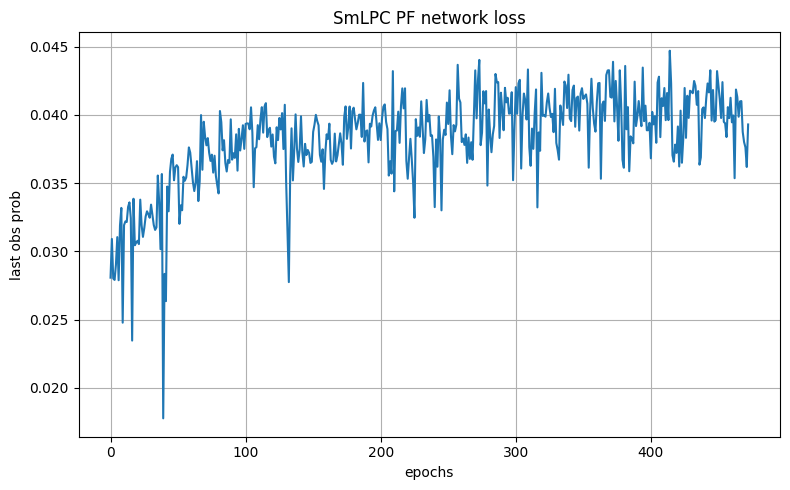

In [ ]:
likelihood = np.exp(-np.array(losses))

plt.figure(figsize=(8, 5))
plt.plot(epochs, likelihood)
plt.xlabel('epochs')
plt.ylabel('last obs prob')
plt.title(f'{perform_name} PF network loss')
plt.grid(True)

plt.tight_layout()
plt.savefig(pfnet_dir /perform_name/"net_training_loss.png", dpi=300) 
np.save(pfnet_dir /perform_name/"net_training_loss.npy", np.array(losses))
plt.show()